In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

from qiskit_aer import AerSimulator
from qiskit import transpile

import pylatexenc

# for testing
# from random import random, randint, choice

import numpy as np
# make numpy output look better
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")

import matplotlib.pyplot as plt
# %matplotlib inline

# style
# plt.rcParams['figure.figsize'] = (10, 8)
# plt.style.use('fivethirtyeight')
plt.style.use("ggplot")

# Five-Qubit Error-Correcting Code

We implement here the [Quantum Five-Qubit Error Correcting Code](https://en.wikipedia.org/wiki/Five-qubit_error_correcting_code), which is a $[[5, 1, 3]]$ code.  We then run experiments with encoded two qubits having the probability of getting a *Pauli error* (i.e., and $X$, $Y$, or $Z$ error) in each of the encoded qubits with a given probability $p$, for a few values of $p$.  So, each error, $X$, $Y$, and $Z$, has a probability of $p$ of occurring in each encoded qubits.  (Therefore, the probability of an encoded qubit having no error is $1 - 3p$.)  We present a visualization of the results.

## Stabilizer Group

We follow Nielsen and Chuang's [Quantum Computation and Quantum Information](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview), Section 10.5.6.

The generators of the stabilizer group are:

$$
  \begin{align*}
    g_0 &= X \otimes Z \otimes Z \otimes X \otimes \mathbb{I}. \\
    g_1 &= \mathbb{I} \otimes X \otimes Z \otimes Z \otimes X ,\\
    g_2 &= X \otimes \mathbb{I} \otimes X \otimes Z \otimes Z ,\\
    g_3 &= Z \otimes X \otimes \mathbb{I} \otimes X \otimes Z, \\
  \end{align*}
$$

Let's encode this information:

In [2]:
g_gates_str = [
    ["x", "z", "z", "x", "i"],
    ["i", "x", "z", "z", "x"],
    ["x", "i", "x", "z", "z"],
    ["z", "x", "i", "x", "z"],
]

Now we create the circuits for each element of the group in the list `g`:

In [3]:
g = []

for gates in g_gates_str:
    quantum_register = QuantumRegister(size=len(gates), name="x")
    circuit = QuantumCircuit(quantum_register)
    for j, gate in enumerate(gates):
        if gate == "x":
            circuit.x(j)
        elif gate == "z":
            circuit.z(j)
    g.append(circuit)

Let's take a look at one of them:

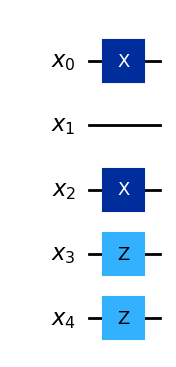

In [4]:
i = 2
g[i].draw("mpl")

## Encoding

According to Nielsen and Chuang, the logical qubits are given by:

$$
\begin{align*}
\left| 0 \right\rangle_L & = \phantom{+} \left|00000\right\rangle -\left|11000\right\rangle + \left|10100\right\rangle -\left|01100\right\rangle \\
&\quad +\left|10010\right\rangle + \left|01010\right\rangle -\left|00110\right\rangle -\left|11110\right\rangle \\
& \quad -\left|10001\right\rangle + \left|01001\right\rangle + \left|00101\right\rangle-\left|11101\right\rangle ,\\ & \quad-\left|00011\right\rangle -\left|11011\right\rangle-\left|10111\right\rangle -\left|01111\right\rangle \\
\left| 1 \right\rangle_L &=  -\left|10000\right\rangle -\left|01000\right\rangle -\left|00100\right\rangle -\left|11100\right\rangle \\
&\quad -\left|00010\right\rangle +\left|11010\right\rangle +\left|10110\right\rangle -\left|01110\right\rangle \\
&\quad  -\left|00001\right\rangle -\left|11001\right\rangle +\left|10101\right\rangle +\left|01101\right\rangle \\
&\quad -\left|10011\right\rangle +\left|01011\right\rangle -\left|00111\right\rangle +\left|11111\right\rangle.
\end{align*}
$$

We follow a clever construction from [Stack Exchange](https://quantumcomputing.stackexchange.com/)'s thread [Nielsen&Chuang 5-qubit quantum error-correction encoding gate](https://quantumcomputing.stackexchange.com/questions/14264/nielsenchuang-5-qubit-quantum-error-correction-encoding-gate) for the encoding:

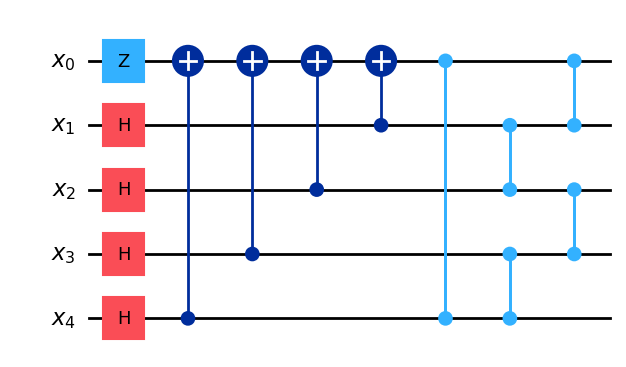

In [5]:
quantum_register = QuantumRegister(size=5, name="x")
encoder_circ = QuantumCircuit(quantum_register)

encoder_circ.z(0)
encoder_circ.h(quantum_register[1:])
for i in range(4):
    encoder_circ.cx(4 - i, 0)
encoder_circ.cz(0, 4)
for i in range(1, 5, 2):
    encoder_circ.cz(i, i + 1)
for i in range(0, 4, 2):
    encoder_circ.cz(i, i + 1)

encoder_circ.draw("mpl")

Let's check that the coefficients are indeed correct.  We start with $\left| 0 \right\rangle_L$.

In [6]:
logical_0 = Statevector(encoder_circ)

Firstly, the scalars in the linear combination should all be real:

In [7]:
for x in logical_0.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


They should also all be $0$ or $\pm 1/4$:

In [8]:
a = np.abs(4 * logical_0.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

Let's print the result to compare to expected value of $\left| 0 \right\rangle_L$:

In [9]:
def binary_digits(a, n):
    """
    Given a and n, returns the first n digits of the binary representation of a.

    INPUTS:
    * a: A positive integer;
    * n: the number of binary digits.

    OUTPUT:
    An array of length n containing the first n binary digits of a, from letft to right.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


for i, coef in enumerate(4 * logical_0.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

  1: [0 0 0 0 0]
 -1: [1 1 0 0 0]
  1: [1 0 1 0 0]
 -1: [0 1 1 0 0]
  1: [1 0 0 1 0]
  1: [0 1 0 1 0]
 -1: [0 0 1 1 0]
 -1: [1 1 1 1 0]
 -1: [1 0 0 0 1]
  1: [0 1 0 0 1]
  1: [0 0 1 0 1]
 -1: [1 1 1 0 1]
 -1: [0 0 0 1 1]
 -1: [1 1 0 1 1]
 -1: [1 0 1 1 1]
 -1: [0 1 1 1 1]


So, it matches!

Now, we repeat the idea for $\left| 1 \right\rangle_L$.  To encode it, we need to use $\left|10000\right\rangle$ as input:

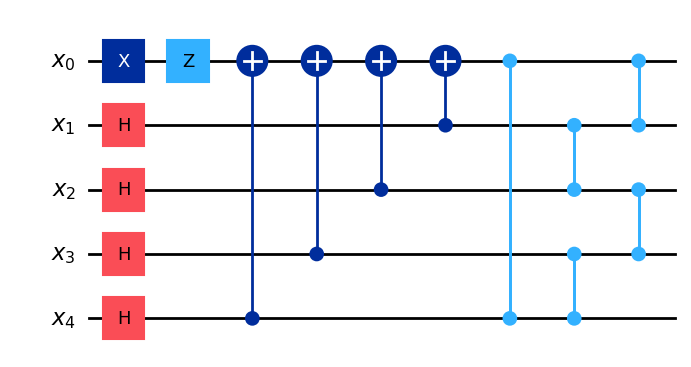

In [10]:
quantum_register = QuantumRegister(size=5, name="x")
circ = QuantumCircuit(quantum_register)

circ.x(0)
circ.compose(encoder_circ, inplace=True)

circ.draw("mpl")

Let's save the state:

In [11]:
logical_1 = Statevector(circ)

Again, we check that the coefficients are all real:

In [12]:
for x in logical_1.data:
    if x.imag != 0:
        print(f"{x} is not real!")
        break
else:
    print("All real!")

All real!


Now we check if they are all either $0$ or $\pm 1/4$:

In [13]:
a = np.abs(4 * logical_1.data)
np.all(np.isclose(a, 0) | np.isclose(a, 1))

np.True_

And we print the result to compare to the expected expression for $\left| 1 \right\rangle_L$:

In [14]:
for i, coef in enumerate(4 * logical_1.data):
    if coef != 0:
        print(f"{np.rint(coef.real).astype(int):>3}: {binary_digits(i, 5)}")

 -1: [1 0 0 0 0]
 -1: [0 1 0 0 0]
 -1: [0 0 1 0 0]
 -1: [1 1 1 0 0]
 -1: [0 0 0 1 0]
  1: [1 1 0 1 0]
  1: [1 0 1 1 0]
 -1: [0 1 1 1 0]
 -1: [0 0 0 0 1]
 -1: [1 1 0 0 1]
  1: [1 0 1 0 1]
  1: [0 1 1 0 1]
 -1: [1 0 0 1 1]
  1: [0 1 0 1 1]
 -1: [0 0 1 1 1]
  1: [1 1 1 1 1]


Again, it matches!

Finally, let's check that $\left| 0 \right\rangle_L$ and $\left| 1 \right\rangle_L$ are indeed $+1$-eigenvalues of the stabilizer group generators, i.e., the $g_i$'s:

In [15]:
quantum_register_1 = QuantumRegister(size=5, name="x")
set_1 = QuantumCircuit(quantum_register_1)
set_1.x(0)

for i, gi in enumerate(g):
    output_0 = Statevector(encoder_circ.compose(gi))
    output_1 = Statevector(set_1.compose(encoder_circ.compose(gi)))

    cond = np.array_equal(output_0.data, logical_0.data) and np.array_equal(output_1, logical_1.data)

    if not cond:
        print("Failed!")
        break
else:
    print("It worked!")

It worked!


## Error Correction

We now introduce the error correction.  We follow [Bernard Zygelman](https://www.physics.unlv.edu/~bernard/)'s [Five and Seven Qubit Codes](https://www.physics.unlv.edu/~bernard/MATH_book/Chap9/Notebook9_3.pdf).

The idea is that if we have a single qubit operator $M$ with eigenvalues $\pm 1$, then we can determine if an eigenvector $\left| \psi \right\rangle$ has eigenvalue $1$ or $-1$ via:

<img src="M-meas.png" alt="Single Qubit Eigenvalue Flip Circuit" width="500"/>

If the measurement yields $0$, then $\left| \psi \right\rangle$ has eigenvalue $+1$, and if it yields $1$, then it has eigenvalue $-1$:

$$
\begin{align*}
\left| \psi \right\rangle \left| 0 \right\rangle
&\mapsto \frac{1}{\sqrt{2}} \left(\left| \psi \right\rangle \left| 0 \right\rangle +  \left| \psi \right\rangle \left| 1 \right\rangle \right) \\
&\mapsto \frac{1}{\sqrt{2}} \left(\left| \psi \right\rangle \left| 0 \right\rangle  \pm  \left| \psi \right\rangle \left| 1 \right\rangle \right) \\
&= \left| \psi \right\rangle \otimes \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle \pm \left| 1 \right\rangle \right) \\
&= \left| \psi \right\rangle \left| (1 - (\pm 1)) /2 \right\rangle.
\end{align*}
$$

We can apply this to $M=X$ and $M=Z$ to detect errors.  Suppose that $g_i$ has a tensor factor of $X$ in the $j$-th qubit. Then, we have that $X_j g_i = g_i X_j$, and if $\left| \psi \right\rangle$ is a $+1$-eigenstate of $g_i$, then
$$
g_i \left(X_j \left| \psi \right\rangle \right) = X_j \left(g_i \left| \psi \right\rangle \right) = X_j \left| \psi \right\rangle,
$$
i.e., $X_j \left| \psi \right\rangle$ is also a $+1$-eigenstate, and our circuit above yields a measurement of $0$.


On the other hand, since $XZ=-ZX$ and $XY = -YX$, we have that $U_j g_i = -g_i U_j$ for $U$ either $Z$ or $Y$, and then
$$
g_i \left(U_j \left| \psi \right\rangle \right) = -U_j \left(g_i \left| \psi \right\rangle \right) = -U_j \left| \psi \right\rangle,
$$
i.e., $U_j \left| \psi \right\rangle$ is now a $-1$-eigenstate, and our circuit above yields a measurement of $1$.

Similarly, if we have instead a tensor factor of $Z$ in the $j$-th qubit, we obtain a measurement of $0$ if we have an $Z$ error in the $j$-th qubit and $1$ if we have either a $Z$ or $Y$ error.

Here is the implementation:

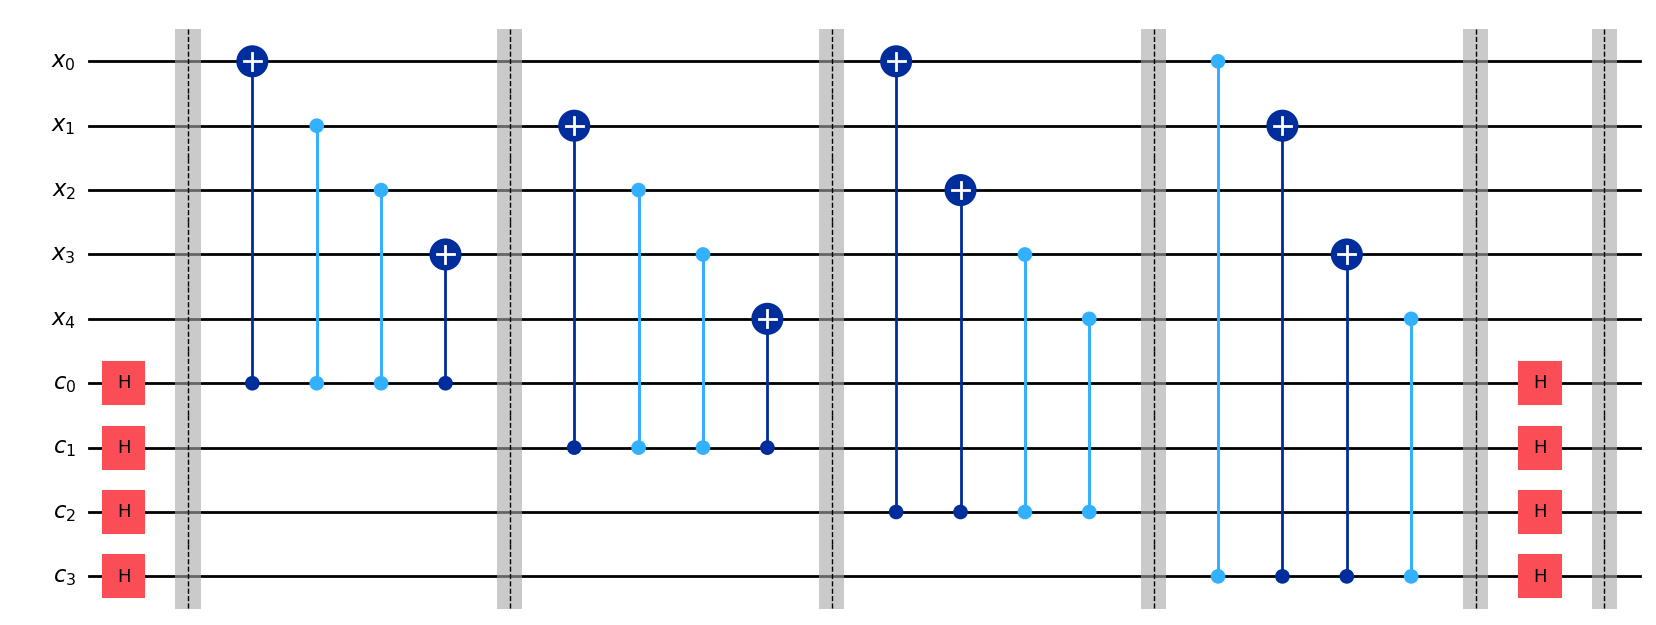

In [16]:
register_size = len(g_gates_str[0])
checks_size = len(g_gates_str)

quantum_register = QuantumRegister(size=register_size, name="x")
checks_register = AncillaRegister(size=checks_size, name="c")

code_circuit = QuantumCircuit(quantum_register, checks_register)

code_circuit.h(checks_register)
code_circuit.barrier()

for i, gates in enumerate(g_gates_str):
    for j, gate in enumerate(gates):
        if gate == "x":
            code_circuit.cx(checks_register[i], quantum_register[j])
        elif gate == "z":
            code_circuit.cz(checks_register[i], quantum_register[j])
    code_circuit.barrier()
code_circuit.h(checks_register)
code_circuit.barrier()

code_circuit.draw("mpl")

In [17]:
# OLD WAY (FROM NOTES -- NOT WORKING)

# register_size = len(g_gates_str[0])
# checks_size = len(g_gates_str)

# quantum_register = QuantumRegister(size=register_size, name="x")
# checks_register = AncillaRegister(size=checks_size, name="c")

# code_circuit = QuantumCircuit(quantum_register, checks_register)

# for i, gates in enumerate(g_gates_str):
#     for j, gate in enumerate(gates):
#         if gate == "x":
#             code_circuit.cx(quantum_register[j], checks_register[i])
#     if "z" in gates:
#         code_circuit.h(checks_register[i])
#         for j, gate in enumerate(gates):
#             if gate == "z":
#                 code_circuit.cx(checks_register[i], quantum_register[j])
#         code_circuit.h(checks_register[i])
#     code_circuit.barrier()

# code_circuit.draw("mpl")

Let's then add the necessary measurements:

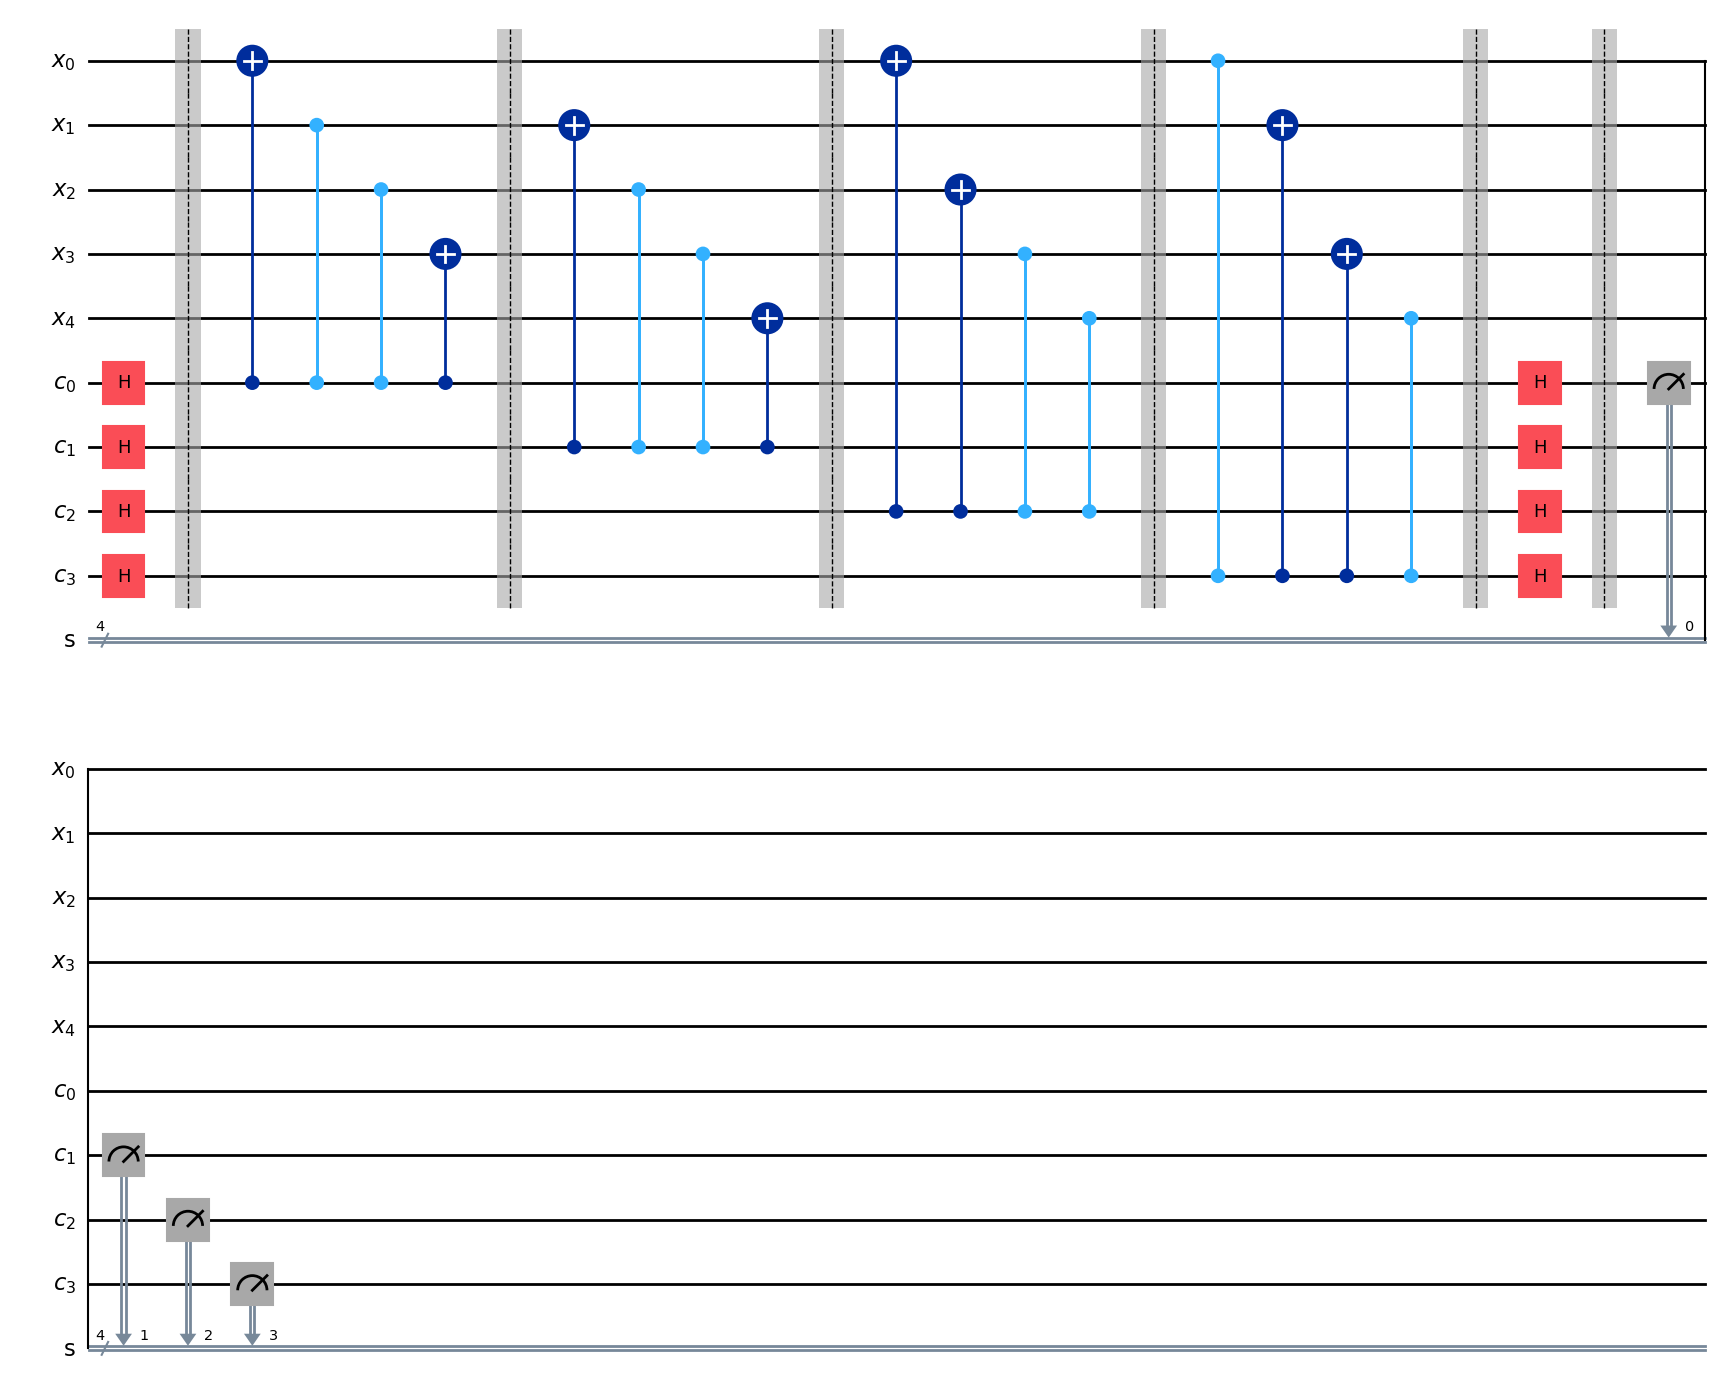

In [18]:
syndromes = ClassicalRegister(size=checks_size, name="s")

code_circuit.add_register(syndromes)

code_circuit.measure(checks_register, syndromes)

code_circuit.draw("mpl")

So, we can produce a table that can gives the measurements for each Pauli error:

In [19]:
n_qubits = len(g_gates_str[0])
n_syndromes = len(g_gates_str)

# save table in dictionary:
decode_dict = {}

for qubit_error in ["x", "z", "y"]:  # possible errors
    for i in range(n_qubits):  # qubit for the error
        syndrome = [0] * n_syndromes
        for j, gi in enumerate(g_gates_str):  # gates
            # print(gi, qubit_error, i, j)
            if gi[i] not in [qubit_error, "i"]:
                syndrome[j] = 1
        decode_dict[(qubit_error, i)] = syndrome
        print(f"{qubit_error}_{i}: {syndrome}")

x_0: [0, 0, 0, 1]
x_1: [1, 0, 0, 0]
x_2: [1, 1, 0, 0]
x_3: [0, 1, 1, 0]
x_4: [0, 0, 1, 1]
z_0: [1, 0, 1, 0]
z_1: [0, 1, 0, 1]
z_2: [0, 0, 1, 0]
z_3: [1, 0, 0, 1]
z_4: [0, 1, 0, 0]
y_0: [1, 0, 1, 1]
y_1: [1, 1, 0, 1]
y_2: [1, 1, 1, 0]
y_3: [1, 1, 1, 1]
y_4: [0, 1, 1, 1]


So, we have:

| Error |   Measurement  | | Error |   Measurement  | | Error |   Measurement  |
|-------|----------------|-|-------|----------------|-|-------|----------------|
| $X_0$ | $(0, 0, 0, 1)$ | | $Z_0$ | $(1, 0, 1, 0)$ | | $Y_0$ | $(1, 0, 1, 1)$ |
| $X_1$ | $(1, 0, 0, 0)$ | | $Z_1$ | $(0, 1, 0, 1)$ | | $Y_1$ | $(1, 1, 0, 1)$ |
| $X_2$ | $(1, 1, 0, 0)$ | | $Z_2$ | $(0, 0, 1, 0)$ | | $Y_2$ | $(1, 1, 1, 0)$ |
| $X_3$ | $(0, 1, 1, 0)$ | | $Z_3$ | $(1, 0, 0, 1)$ | | $Y_3$ | $(1, 1, 1, 1)$ |
| $X_4$ | $(0, 0, 1, 1)$ | | $Z_4$ | $(0, 1, 0, 0)$ | | $Y_4$ | $(0, 1, 1, 1)$ |


So, the measurements tell us which error occurred, and we can fix it by applying the same operator.  For instance, if we measure $(0,0,1,0)$ we apply $Z_2$ to the circuit.


The data of the table above is saved in a dictionary:

In [20]:
decode_dict

{('x', 0): [0, 0, 0, 1],
 ('x', 1): [1, 0, 0, 0],
 ('x', 2): [1, 1, 0, 0],
 ('x', 3): [0, 1, 1, 0],
 ('x', 4): [0, 0, 1, 1],
 ('z', 0): [1, 0, 1, 0],
 ('z', 1): [0, 1, 0, 1],
 ('z', 2): [0, 0, 1, 0],
 ('z', 3): [1, 0, 0, 1],
 ('z', 4): [0, 1, 0, 0],
 ('y', 0): [1, 0, 1, 1],
 ('y', 1): [1, 1, 0, 1],
 ('y', 2): [1, 1, 1, 0],
 ('y', 3): [1, 1, 1, 1],
 ('y', 4): [0, 1, 1, 1]}

We will need the `code_circuit` intact for later, so we create now a copy to test the error correction:

In [21]:
code_test = code_circuit.copy()

Let's create a function that apply tests the measurements and applies the corrections:

In [22]:
def add_5_qubit_correction(circuit, qubits, syndromes, decode_dict):
    """
    Adds correction for five-qubit code circuit (in-place) using a decoding table.

    INPUT:
    * circuit: the circuit containing the five-qubit code;
    * qubtis: register for the qubits and checks;
    * syndromes: syndromes containing the measurements;
    * decode_dict: dictionary containing the decoding table.
    """
    for error, values in decode_dict.items():
        with circuit.if_test((syndromes[0], values[0])):
            with circuit.if_test((syndromes[1], values[1])):
                with circuit.if_test((syndromes[2], values[2])):
                    with circuit.if_test((syndromes[3], values[3])):
                        if error[0] == "x":
                            circuit.x(qubits[error[1]])
                        elif error[0] == "z":
                            circuit.z(qubits[error[1]])
                        elif error[0] == "y":
                            circuit.y(qubits[error[1]])

Let's then add corrections to `code_test`:

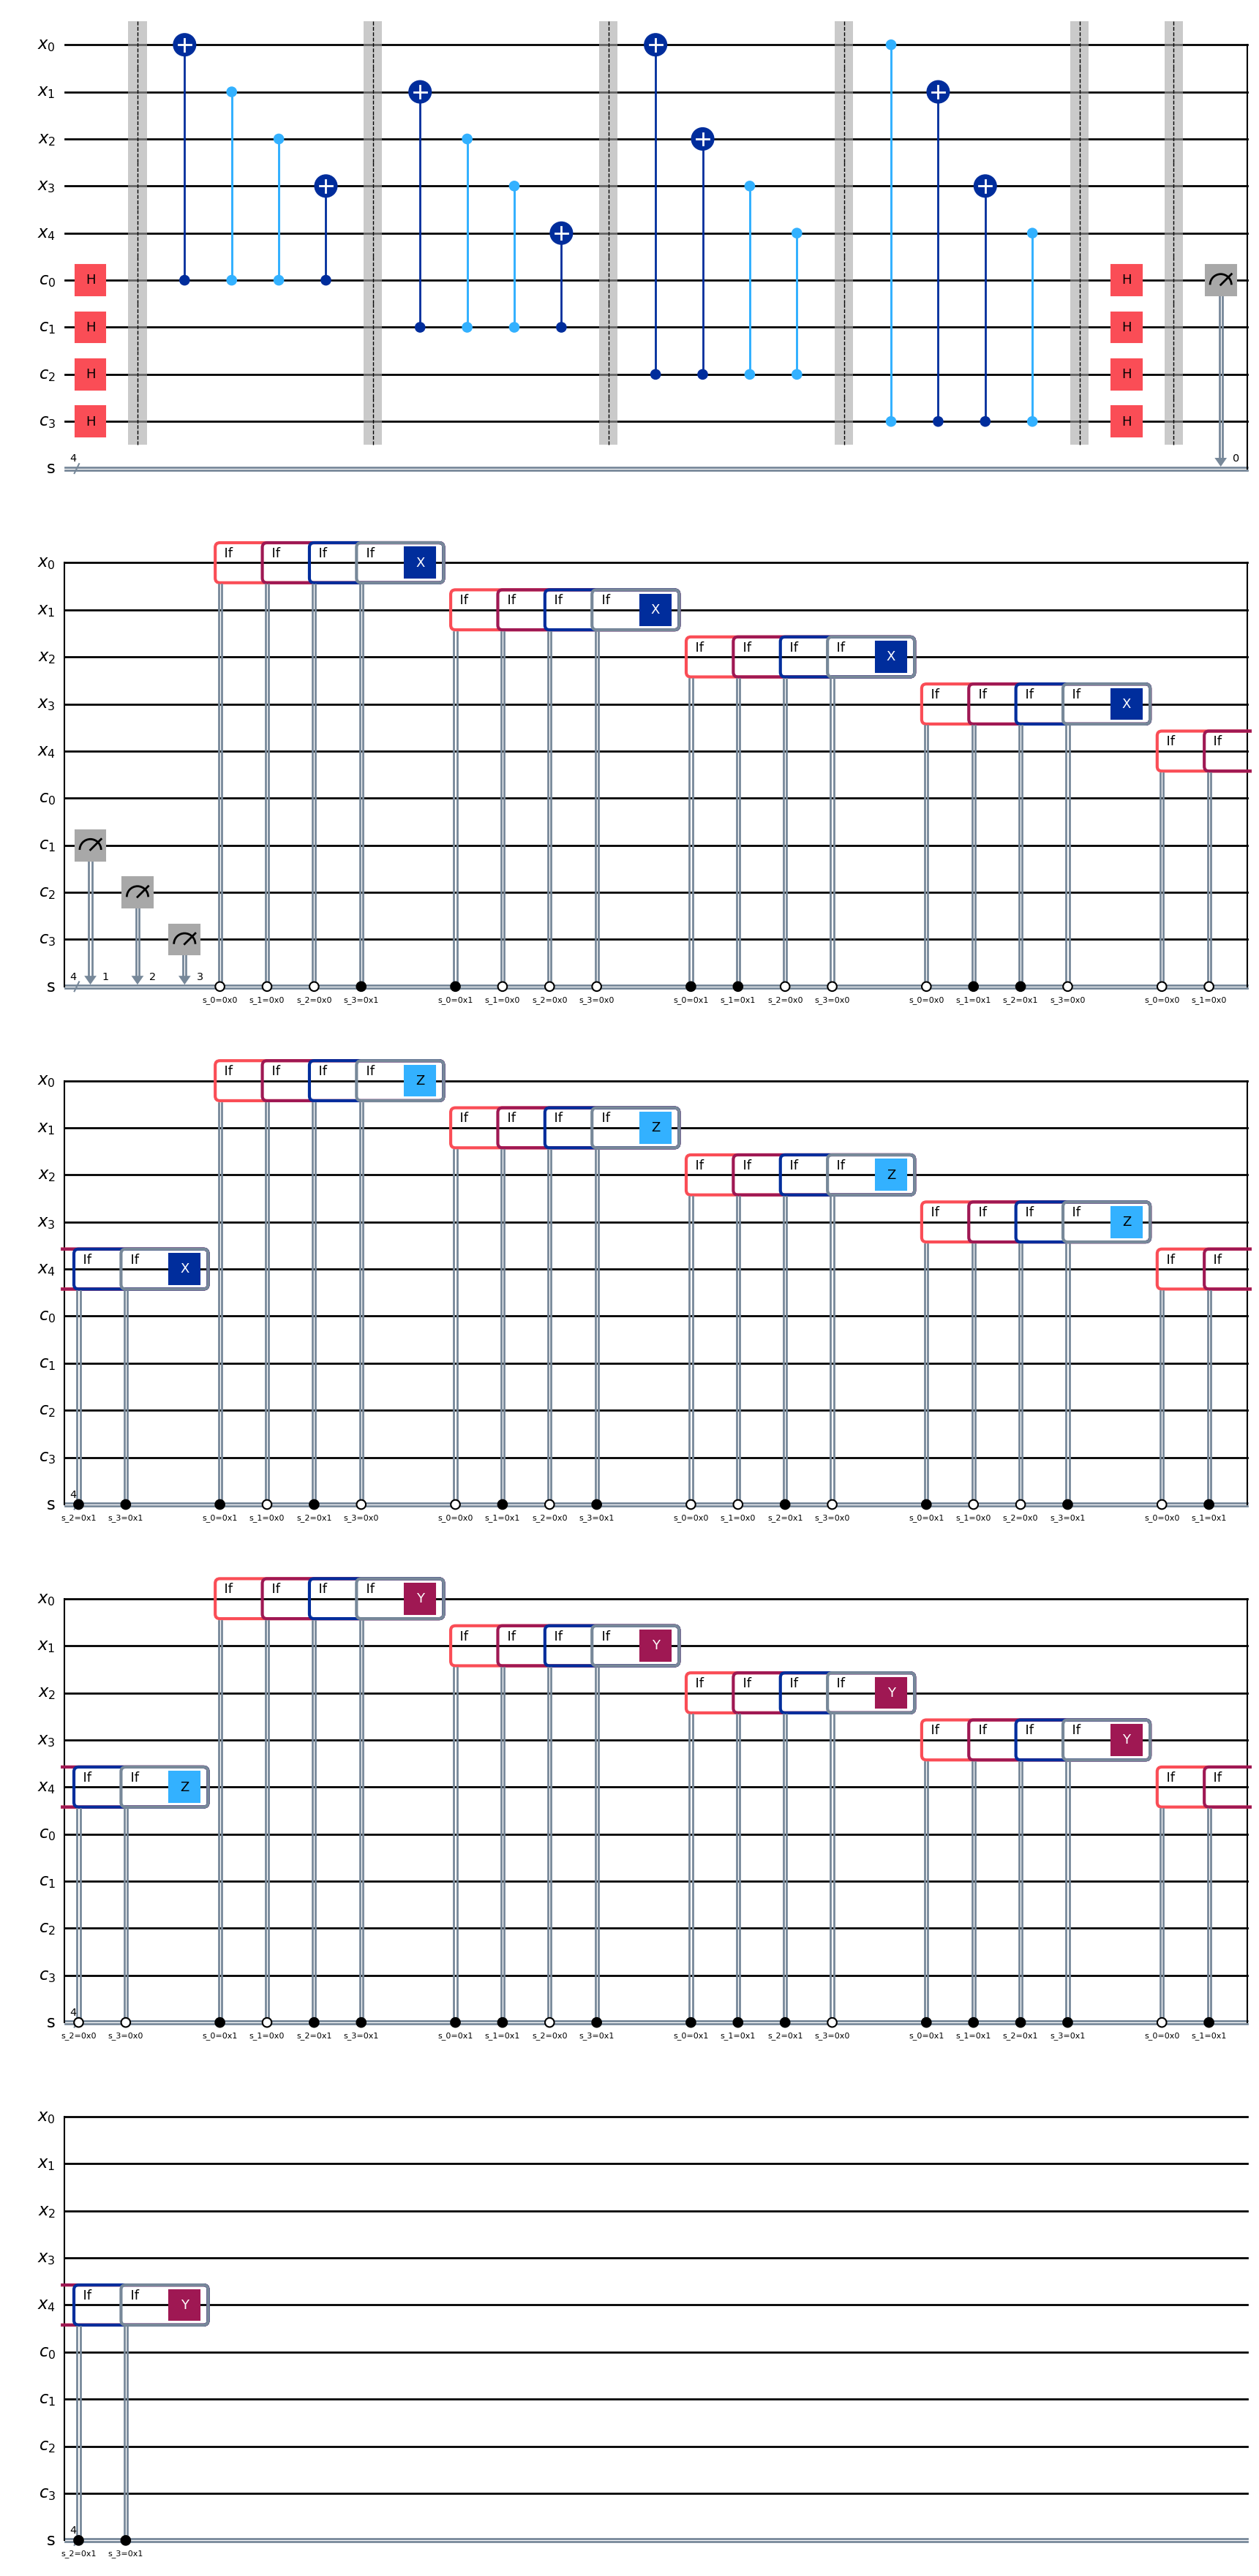

In [23]:
add_5_qubit_correction(code_test, code_test.qubits[0:5], code_test.clbits, decode_dict)

code_test.draw("mpl")

Let's now test the correction of a single Pauli error:

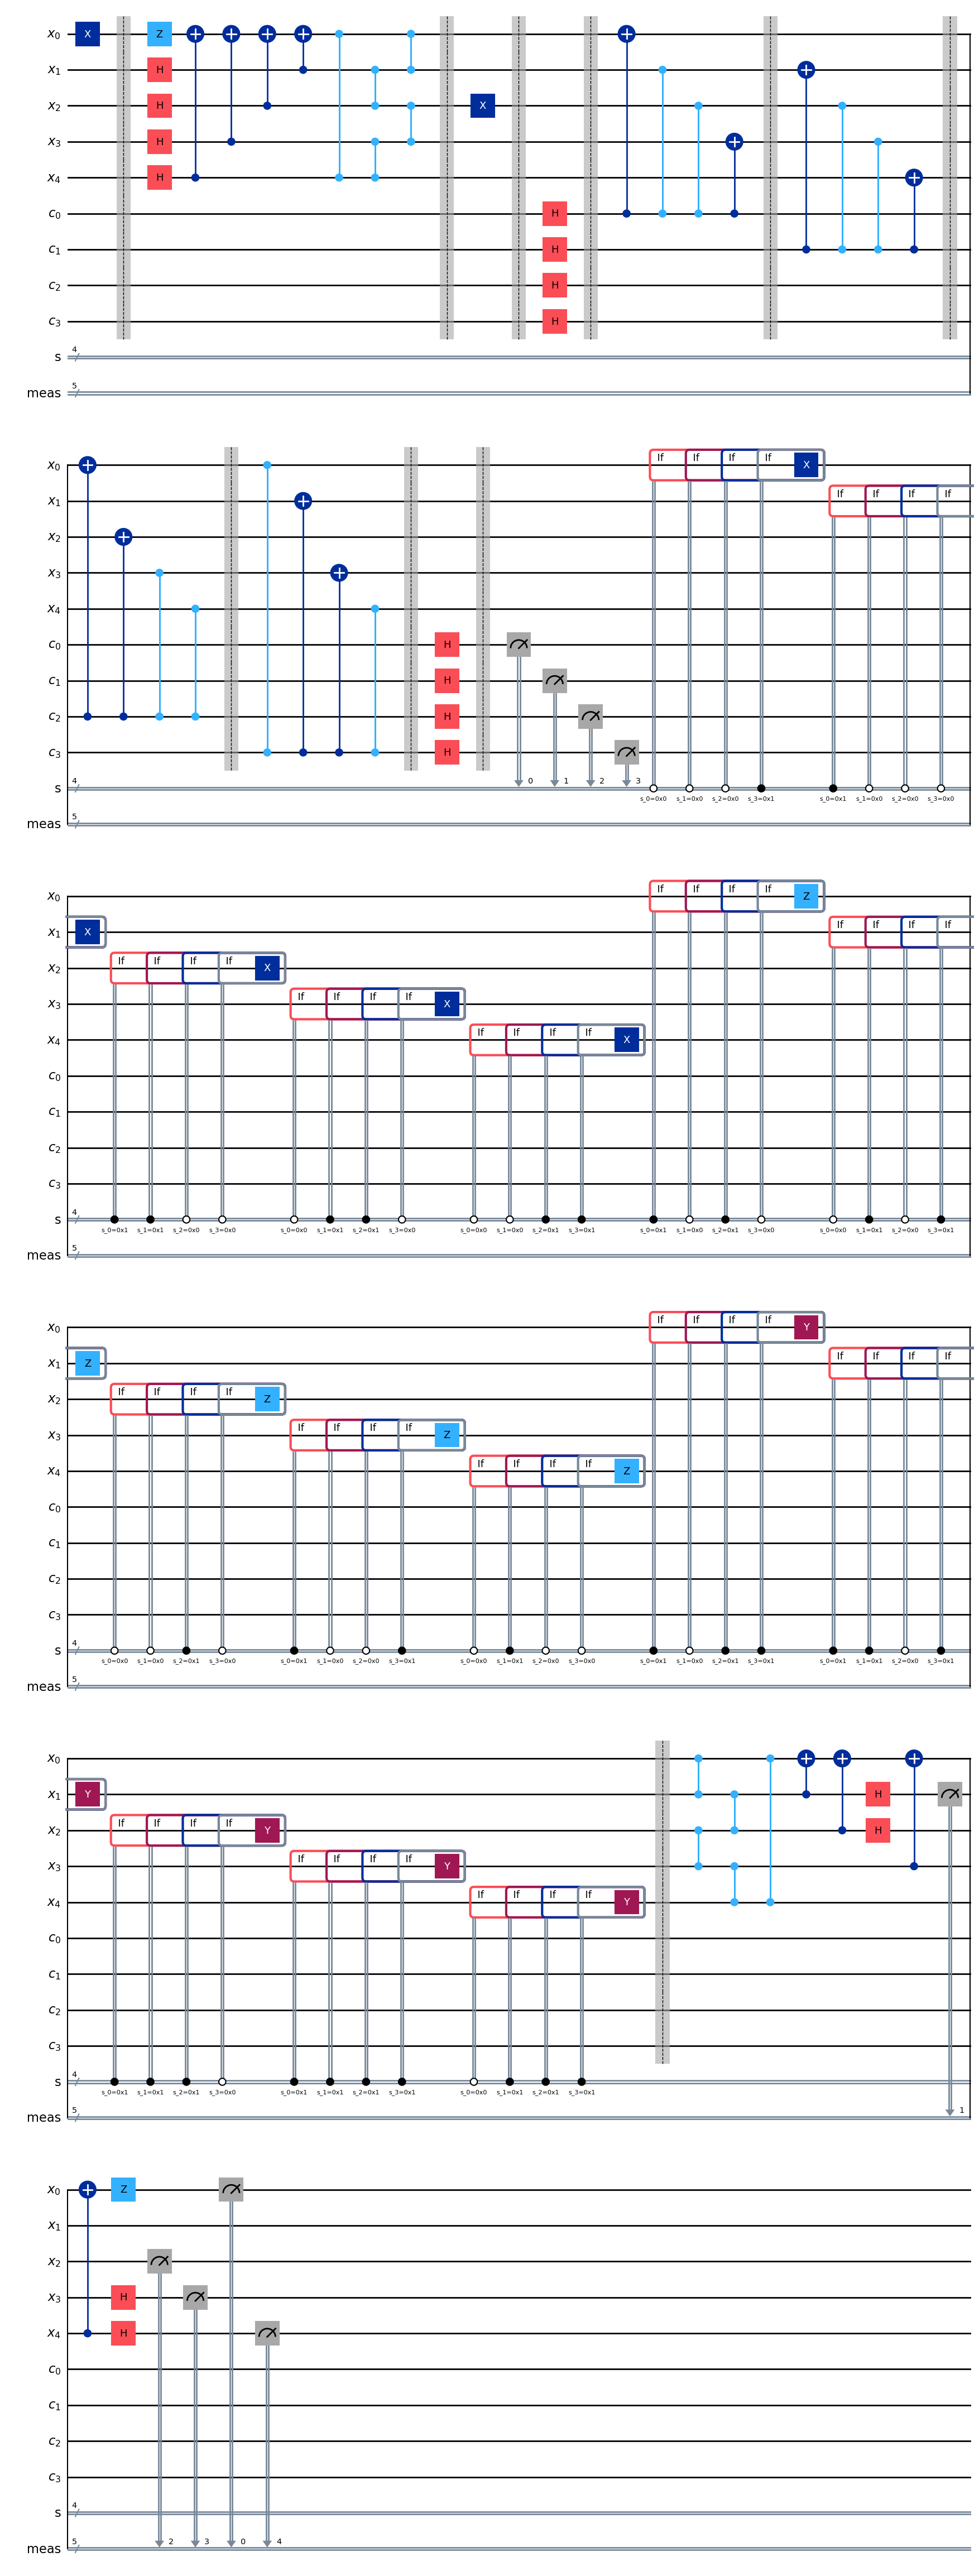

In [24]:
# enter 0 for |0> and 1 for |1>
encode_value = 1

# enter string for the error and its position
error_gate = "x"
error_position = 2


quantum_register = QuantumRegister(size=5, name="x")
checks_register = AncillaRegister(size=4, name="c")
syndromes = ClassicalRegister(size=4, name="s")

qubit_measurements = ClassicalRegister(size=5, name="meas")

test_circuit = QuantumCircuit(quantum_register, checks_register, syndromes)

# encode correct value
if encode_value == 1:
    test_circuit.x(quantum_register[0])
    test_circuit.barrier()

# encode
test_circuit.compose(encoder_circ, inplace=True)
test_circuit.barrier()

# add error
if error_gate == "x":
    test_circuit.x(quantum_register[error_position])
elif error_gate == "y":
    test_circuit.y(quantum_register[error_position])
elif error_gate == "z":
    test_circuit.z(quantum_register[error_position])
test_circuit.barrier()

# add code
test_circuit.compose(code_test, inplace=True)
test_circuit.barrier()

# decode
test_circuit.compose(encoder_circ.inverse(), inplace=True)

# measure
test_circuit.add_register(qubit_measurements)
test_circuit.measure(quantum_register, qubit_measurements)

test_circuit.draw("mpl")

Now, let's run a simulation:

In [25]:
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(test_circuit, simulator)

# Run the circuit -- shot probably could be 1...
job = simulator.run(compiled_circuit, shots=10)

# Get the measurement counts
counts = job.result().get_counts()
counts

{'00001 0011': 10}

We should get back the encoded qubit:

In [26]:
list(counts.keys())[0].split()[0][::-1] == str(encode_value) + 4 * "0"

True

## Two Qubit Encoding/Decoding and Test

We now we will encode two qubits and test for errors.  We will make the test into a function, but let's do a manual test first:

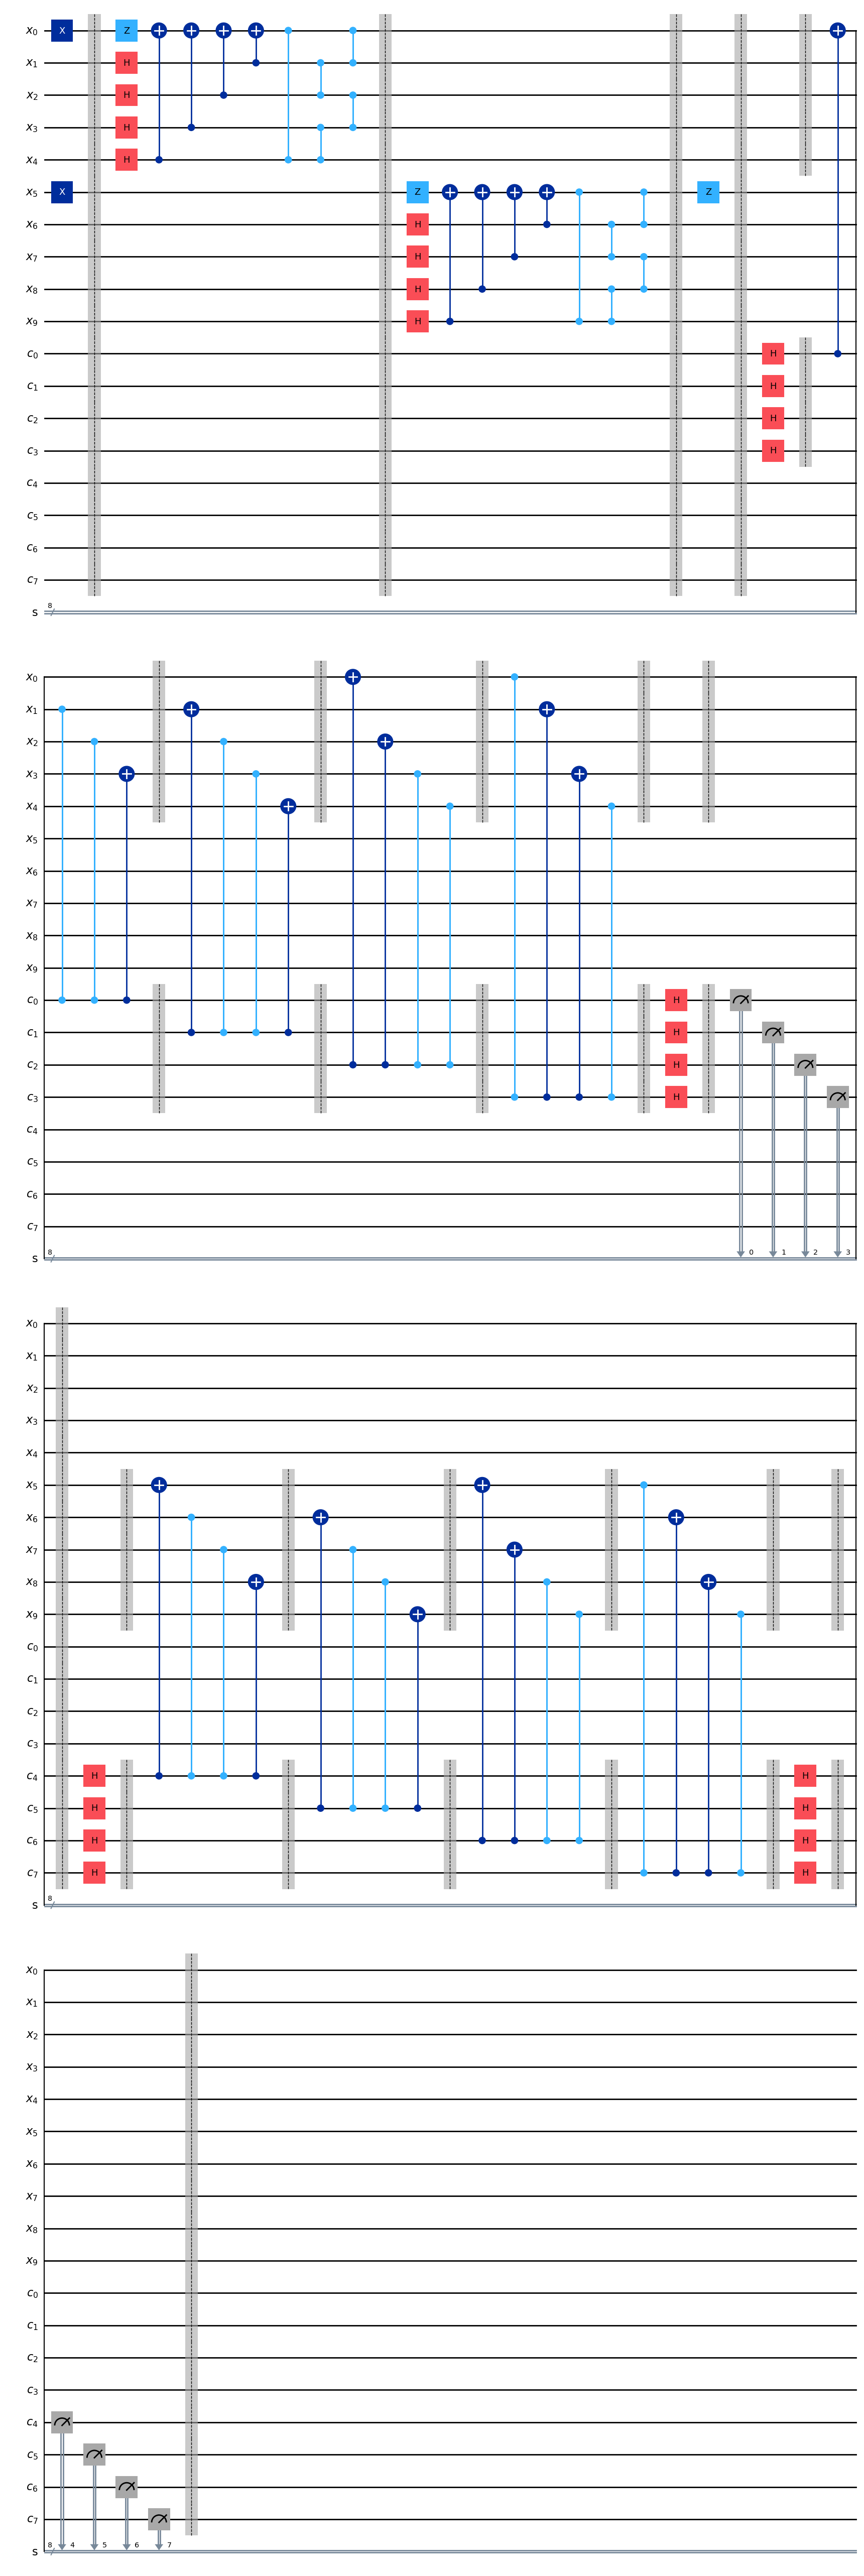

In [27]:
p = 0.05  # probability of error for each encoded qubit
qubits_str = "11"  # encoded pair of qubits

#######################
n_qubits = 5
n_ancillas = 4

# create the circuit
quantum_register = QuantumRegister(size=2 * n_qubits, name="x")
checks_register = AncillaRegister(size=2 * n_ancillas, name="c")
syndromes = ClassicalRegister(size=2 * n_ancillas, name="s")

test_circuit = QuantumCircuit(
    quantum_register,
    checks_register,
    syndromes,
)

# set initial state
for i in range(2):
    if qubits_str[i] == "1":
        test_circuit.x(quantum_register[i * n_qubits])
test_circuit.barrier()

# encoders
for i in range(2):
    test_circuit.compose(
        encoder_circ, quantum_register[i * n_qubits : (i + 1) * n_qubits], inplace=True
    )
    test_circuit.barrier()

# random errors
error_occurred = ["i"] * (2 * n_qubits)
for i in range(2 * n_qubits):
    rnd = np.random.random(3)
    # X error
    if rnd[0] < p:
        test_circuit.x(quantum_register[i])
        error_occurred[i] = "x"
    # Y error
    if rnd[1] < p:
        test_circuit.y(quantum_register[i])
        if error_occurred[i] == "i":
            error_occurred[i] = "y"
        else:
            error_occurred[i] += "y"
    # Z error
    if rnd[2] < p:
        test_circuit.z(quantum_register[i])
        if error_occurred[i] == "i":
            error_occurred[i] = "z"
        else:
            error_occurred[i] += "z"
    # reverse order to see it as composition (right to left)
    error_occurred[i] = error_occurred[i][::-1]
test_circuit.barrier()

# add code_circuit (created above)
for i in range(2):
    test_circuit.compose(
        code_circuit,
        qubits=
            list(range(i * n_qubits, (i + 1) * n_qubits))
            + list(
                range(
                    2 * n_qubits + i * n_ancillas, 
                    2 * n_qubits + (i + 1) * n_ancillas
                )
            ),
        clbits=syndromes[i * n_ancillas : (i + 1) * n_ancillas],
        inplace=True,
    )
    test_circuit.barrier()

test_circuit.draw("mpl")

Let's see what was the error.  (If we only have a single error for each of the five encoded qubits, the correction should work.)

In [28]:
error_occurred

['i', 'i', 'i', 'i', 'i', 'z', 'i', 'i', 'i', 'i']

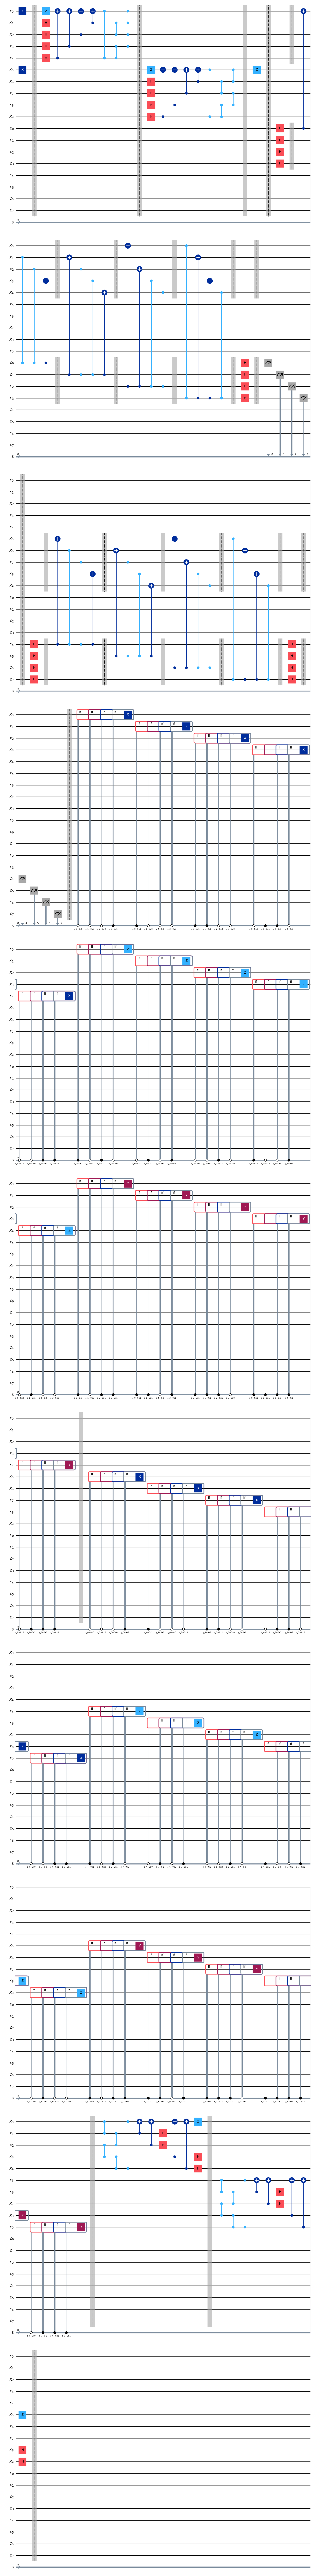

In [29]:
for i in range(2):
    add_5_qubit_correction(
        test_circuit, 
        quantum_register[i * n_qubits: (i + 1) * n_qubits],
        syndromes[i * n_ancillas: (i + 1) * n_ancillas],
        decode_dict
    )
    test_circuit.barrier()

for i in range(2):
    test_circuit.compose(encoder_circ.inverse(), quantum_register[i * n_qubits: (i + 1) * n_qubits], inplace=True)
    test_circuit.barrier()

test_circuit.draw("mpl")

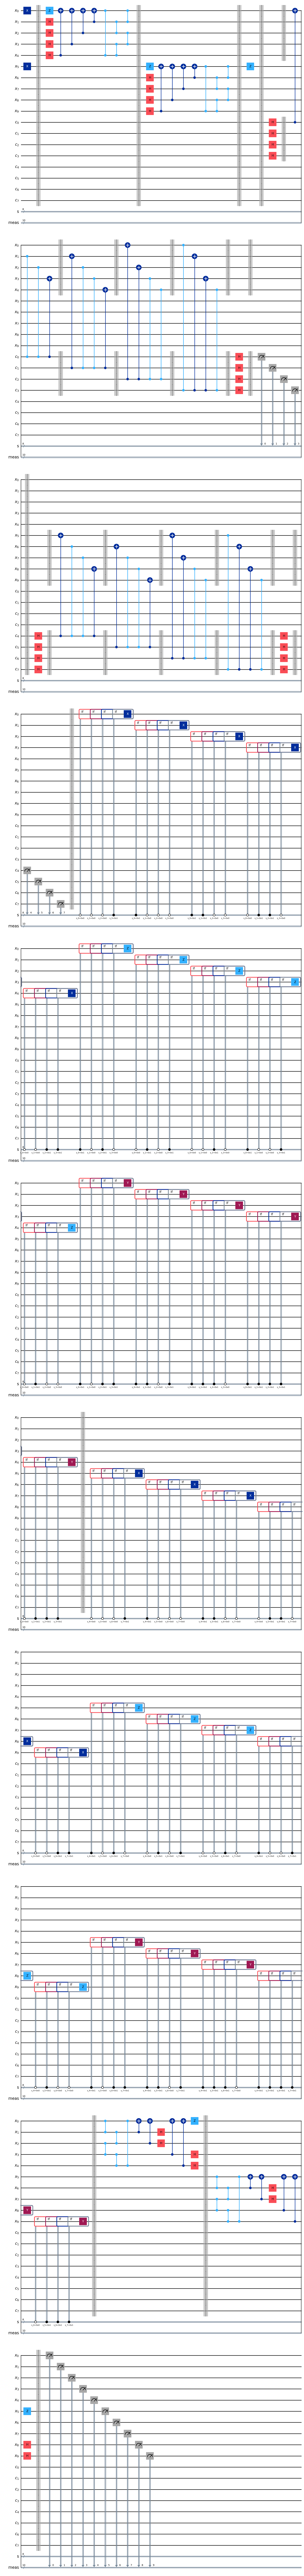

In [30]:
qubit_measurements = ClassicalRegister(size=2 * n_qubits, name="meas")

test_circuit.add_register(qubit_measurements)
test_circuit.measure(quantum_register, qubit_measurements)

test_circuit.draw("mpl")

Now, we simulate:

In [31]:
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(test_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=10)

# Get the measurement counts
counts = job.result().get_counts()
counts

{'0000100001 01010000': 10}

Now we compare with our input:

In [32]:
result = {qubits.split()[0] for qubits in counts}.pop()[::-1]

# get the logical form of each qubit
result_split = [result[:n_qubits], result[n_qubits : 2 * n_qubits]]

# check
result_split[0] == qubits_str[0] + "0" * 4, result_split[1] == qubits_str[1] + "0" * 4

(True, True)

Now, let's turn it into a function:

In [33]:
def test_5_qubit_code(qubits_str, p, decode_dict, shots=10):
    n_qubits = 5
    n_ancillas = 4

    # registers
    quantum_register = QuantumRegister(size=2 * n_qubits, name="x")
    checks_register = AncillaRegister(size=2 * n_ancillas, name="c")
    syndromes = ClassicalRegister(size=2 * n_ancillas, name="s")

    # circuit
    test_circuit = QuantumCircuit(
        quantum_register,
        checks_register,
        syndromes,
    )

    # set initial state
    for i in range(2):
        if qubits_str[i] == "1":
            test_circuit.x(quantum_register[i * n_qubits])

    # encoders
    for i in range(2):
        test_circuit.compose(
            encoder_circ,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )

    # random errors
    error_occurred = ["i"] * (2 * n_qubits)
    for i in range(2 * n_qubits):
        rnd = np.random.random(3)
        # X error
        if rnd[0] < p:
            test_circuit.x(quantum_register[i])
            error_occurred[i] = "x"
        # Y error
        if rnd[1] < p:
            test_circuit.y(quantum_register[i])
            if error_occurred[i] == "i":
                error_occurred[i] = "y"
            else:
                error_occurred[i] += "y"
        # Z error
        if rnd[2] < p:
            test_circuit.z(quantum_register[i])
            if error_occurred[i] == "i":
                error_occurred[i] = "z"
            else:
                error_occurred[i] += "z"
        # reverse order to see it as composition (right to left)
        error_occurred[i] = error_occurred[i][::-1]

    # encoding + correction
    # NEEDS code_circuit TO BE CONSTRUCTED FIRST!
    for i in range(2):
        test_circuit.compose(
            code_circuit,
            qubits=list(range(i * n_qubits, (i + 1) * n_qubits))
            + list(
                range(
                    2 * n_qubits + i * n_ancillas, 2 * n_qubits + (i + 1) * n_ancillas
                )
            ),
            clbits=syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            inplace=True,
        )

    # recovery
    for i in range(2):
        add_5_qubit_correction(
            test_circuit,
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            syndromes[i * n_ancillas : (i + 1) * n_ancillas],
            decode_dict
        )

    # decoding
    for i in range(2):
        test_circuit.compose(
            encoder_circ.inverse(),
            quantum_register[i * n_qubits : (i + 1) * n_qubits],
            inplace=True,
        )
        test_circuit.barrier()

    # add measurements
    qubit_measurements = ClassicalRegister(size=2 * n_qubits, name="meas")
    test_circuit.add_register(qubit_measurements)
    test_circuit.measure(quantum_register, qubit_measurements)

    # simulation
    simulator = AerSimulator()

    # Transpile the circuit for the backend
    compiled_circuit = transpile(test_circuit, simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=shots)

    # Get the measurement counts
    counts = job.result().get_counts()

    # check results
    # more than one result?
    results = {qubits.split()[0] for qubits in counts}
    if len(results) > 1:
        return False, error_occurred

    # REVERSE the result!
    result = results.pop()[::-1]

    # get the logical form of each qubit
    result_split = [result[:n_qubits], result[n_qubits : 2 * n_qubits]]

    # check
    for res, qubit in zip(result_split, list(qubits_str)):
        if res != qubit + "0" * (n_qubits - 1):
            return False, error_occurred

    return True, error_occurred

Let's run a single test:

In [34]:
test_5_qubit_code("11", 0.15, decode_dict)

(False, ['i', 'x', 'i', 'y', 'i', 'y', 'i', 'i', 'y', 'z'])

Let's now collect data for different values of $p$.  (**Note:** It can take a long time to run it!)

In [35]:
%%time
max_prob = 0.17
step = 0.01

xs = np.arange(0, max_prob + step, step)
ys = np.zeros_like(xs)

number_of_tries = 100

for i, p in enumerate(xs):
    count = 0
    for _ in range(number_of_tries):
        qubits_str = "".join(np.random.choice(["0", "1"], 2))
        res, _ = test_5_qubit_code(qubits_str, p, decode_dict)
        if res:
            count += 1
        ys[i] = count / number_of_tries

CPU times: user 38min 14s, sys: 3.65 s, total: 38min 18s
Wall time: 11min 41s


Here are is the table with the percentage of correctly decoded pairs of qubits:

In [36]:
print(f"{'p':^6} | percentage")
print("------ | ---------- ")
for x, y in zip(xs, ys):
    print(f"{x:^6.2f} | {y:^10.2f}")

  p    | percentage
------ | ---------- 
 0.00  |    1.00   
 0.01  |    1.00   
 0.02  |    0.97   
 0.03  |    0.87   
 0.04  |    0.81   
 0.05  |    0.79   
 0.06  |    0.72   
 0.07  |    0.77   
 0.08  |    0.68   
 0.09  |    0.64   
 0.10  |    0.51   
 0.11  |    0.48   
 0.12  |    0.55   
 0.13  |    0.40   
 0.14  |    0.42   
 0.15  |    0.44   
 0.16  |    0.44   
 0.17  |    0.35   


Here is the corresponding plot:

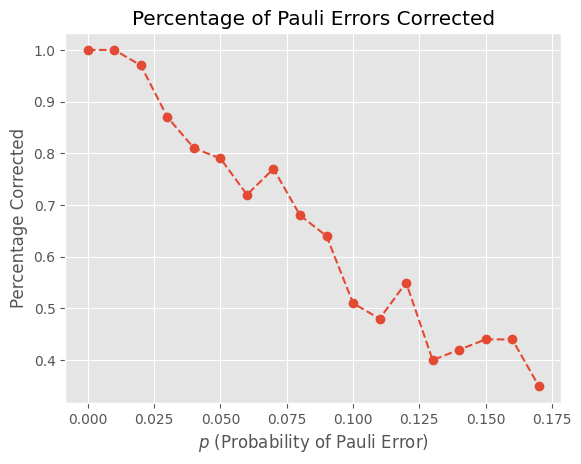

In [37]:
plt.plot(xs, ys, "--o");
plt.title("Percentage of Pauli Errors Corrected")
plt.xlabel("$p$ (Probability of Pauli Error)")
plt.ylabel("Percentage Corrected")

# plt.savefig("5-qb.png")

plt.show()

Below is the hard coded data from one run:

In [38]:
ys_found = np.array([1.  , 0.98, 0.94, 0.91, 0.93, 0.77, 0.66, 0.71, 0.65, 0.53, 0.6 ,
       0.53, 0.44, 0.43, 0.42, 0.33, 0.47, 0.42])

Here is the table for that run:

|   $p$   | percentage |
|---------|:----------:|
| $0.00$  |   $1.00$   |
| $0.01$  |   $0.98$   |
| $0.02$  |   $0.94$   |
| $0.03$  |   $0.91$   |
| $0.04$  |   $0.93$   |
| $0.05$  |   $0.77$   |
| $0.06$  |   $0.66$   |
| $0.07$  |   $0.71$   |
| $0.08$  |   $0.65$   |
| $0.09$  |   $0.53$   |
| $0.10$  |   $0.60$   |
| $0.11$  |   $0.53$   |
| $0.12$  |   $0.44$   |
| $0.13$  |   $0.43$   |
| $0.14$  |   $0.42$   |
| $0.15$  |   $0.33$   |
| $0.16$  |   $0.47$   |
| $0.17$  |   $0.42$   |

Here is the corresponding graph:

<img src="5-qb.png" alt="Percentage Corrected for One Run"/>